# Group 1 Fragment Computer Vision
---
Abbreviations:
- **CV**: Computer vision </br>
- **IAP**: Interactive architecture prototypes
---

This is the script used for Group 1's computer vision processing in our Martian Habitat Design for the Interactive Architecture Workshop in Q3 2023. More information on our project can be found on the official [CS Wiki](http://cs.roboticbuilding.eu/index.php/Shared:2023W4G1Design).

Written by Tom Punte, Augusta Fiseryte and Arno Decorte 🤖

Under the supervision of Casper van Engelenburg and Seyran Khademi

Start by checking your Python Version. This particular notebook was written in Python 3.9.16

In [ ]:
!python --version

Python 3.9.16


## Import IA-CV library

First install the package `requests` in order to create a library from an (online and open available) python script.

The 'requests' package is a popular Python package that allows you to send HTTP/1.1 requests extremely easily.

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Check if 'requests' package is installed.

In [ ]:
import sys
'requests' in sys.modules

True

Download the computer vision python library from github.

In [ ]:
import requests

def url2libary(url):
    
    #get url
    r = requests.get(url)

    # set the filename as iacv.py 
    with open('iacv.py', 'w') as f:
        f.write(r.text)

# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/caspervanengelenburg/CV-sessions-IAP-course/main/2023/iacv_lib.py'

url2libary(url)

Import our own library, IACV

In [ ]:
import iacv

Use `inspect.getmembers`* to check all methods within a library. We do so for our own library `iacv`. 

*inspect.getmembers() returns a list of all the members (functions, classes, variables, etc.) of an object, which can then be filtered using the isfunction() method to only select the functions.

In [ ]:
from inspect import getmembers, isfunction
function_list = getmembers(iacv, isfunction)

# getmembers outputs a list of functions of the library that is inputted.
# loop over the list and print every function sequentially.
for function in function_list:
  print(function[0])

blur
border2color
concat_images_horizontally
contours2polygons
dilate
edge
erode
findcnts
get_angle_from_line
get_angles
get_hole_polygons_from_contours
get_largest_edge_from_polygon
getshape
imresize
imshow
pix2metric
pixpermetric
plot_polygon
plot_robot_grab
rgb2gray
simplify_by_angle
simplify_polygons
warp


This is a list of functions that are available for our disposal as part of this assignment. In this script we will be working with x,y,z

## Creating an image composite

As part of this assigment, we'd like to explore how we can use python to fulfill tasks that would normally be done on an image processing software like photoshop. 

In this case, We will use the Python Imaging Library and it's fork Pillow. These are Python libraries that provide support for opening, manipulating, and saving many different image file formats.

First, import the `Image` and `Image Enhance` module from `PIL`. This is the module that is used for resizing, cropping, rotating, flipping, and filtering images, among other operations. In our case we will use it to overlay two images, a foreground and a background.

In [ ]:
from PIL import Image, ImageEnhance

We will use this to overlay our modules as a foreground, over a background that is slightly off-white (taken a table). This will help optimize our code to work with a real-life environment.

Let's now import the two images and preview them:

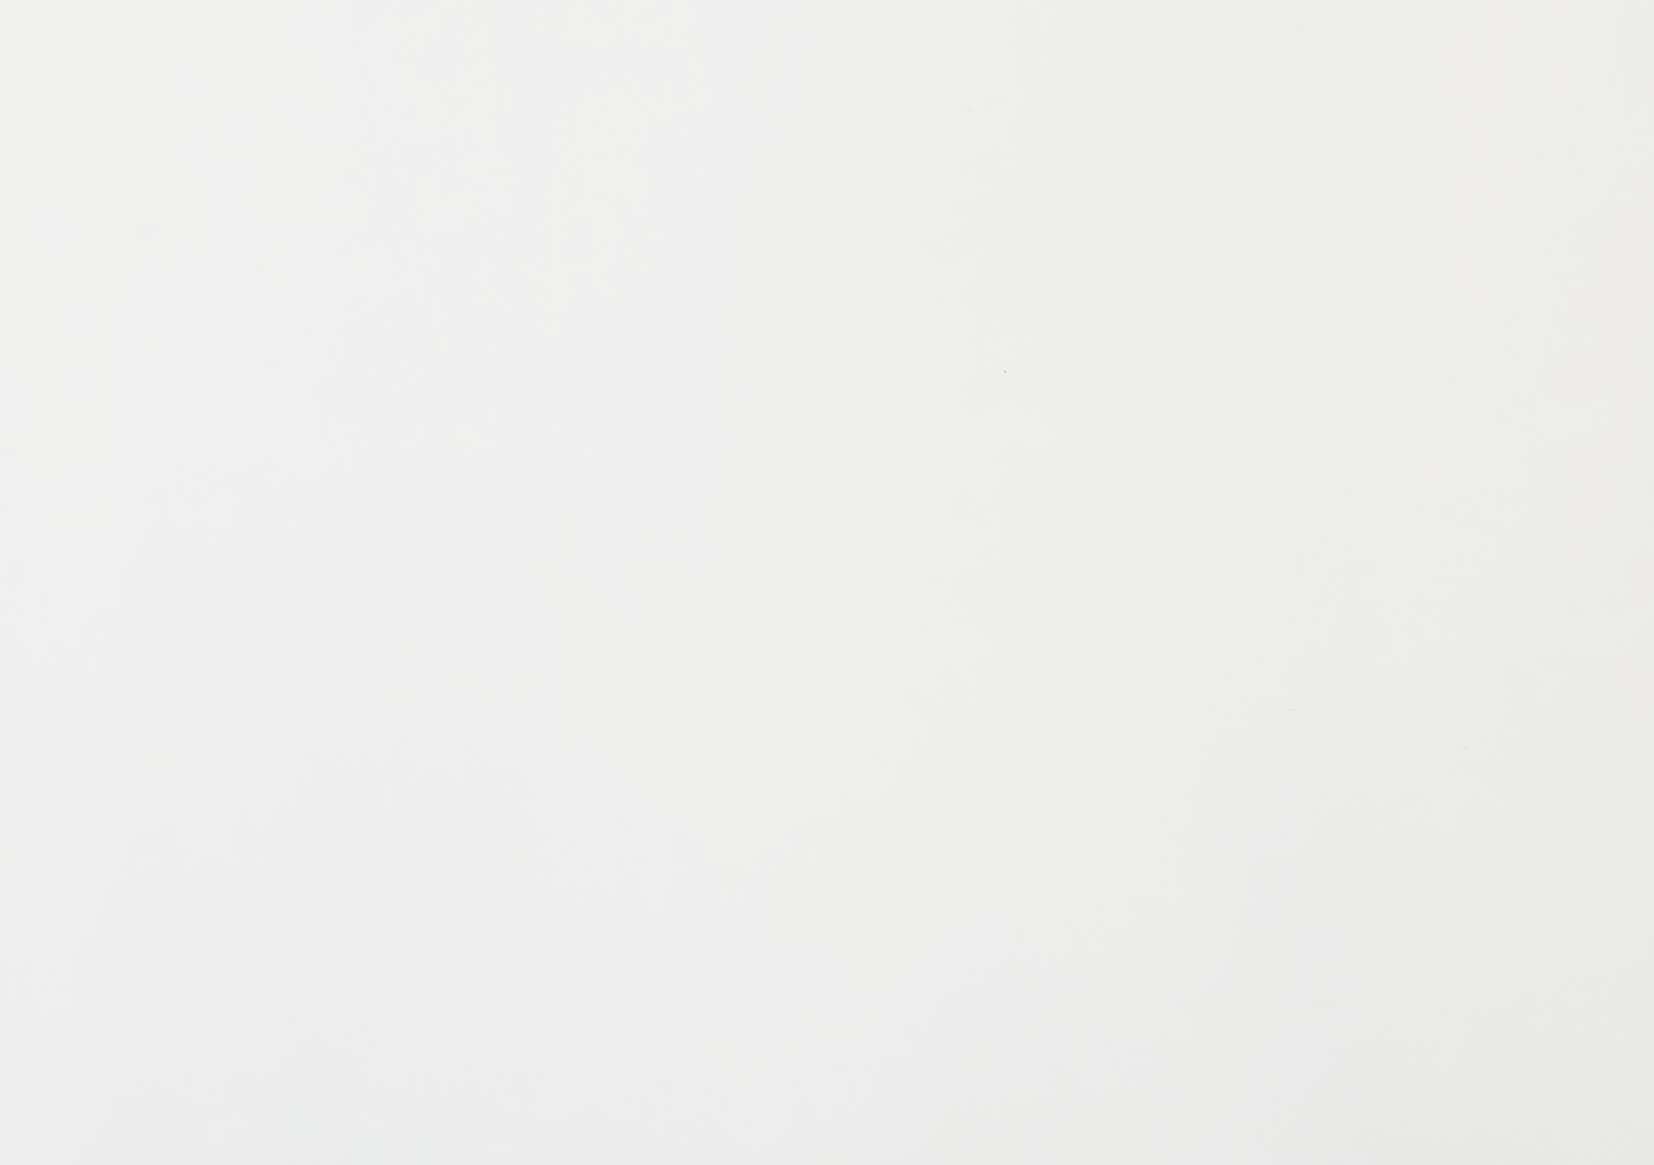

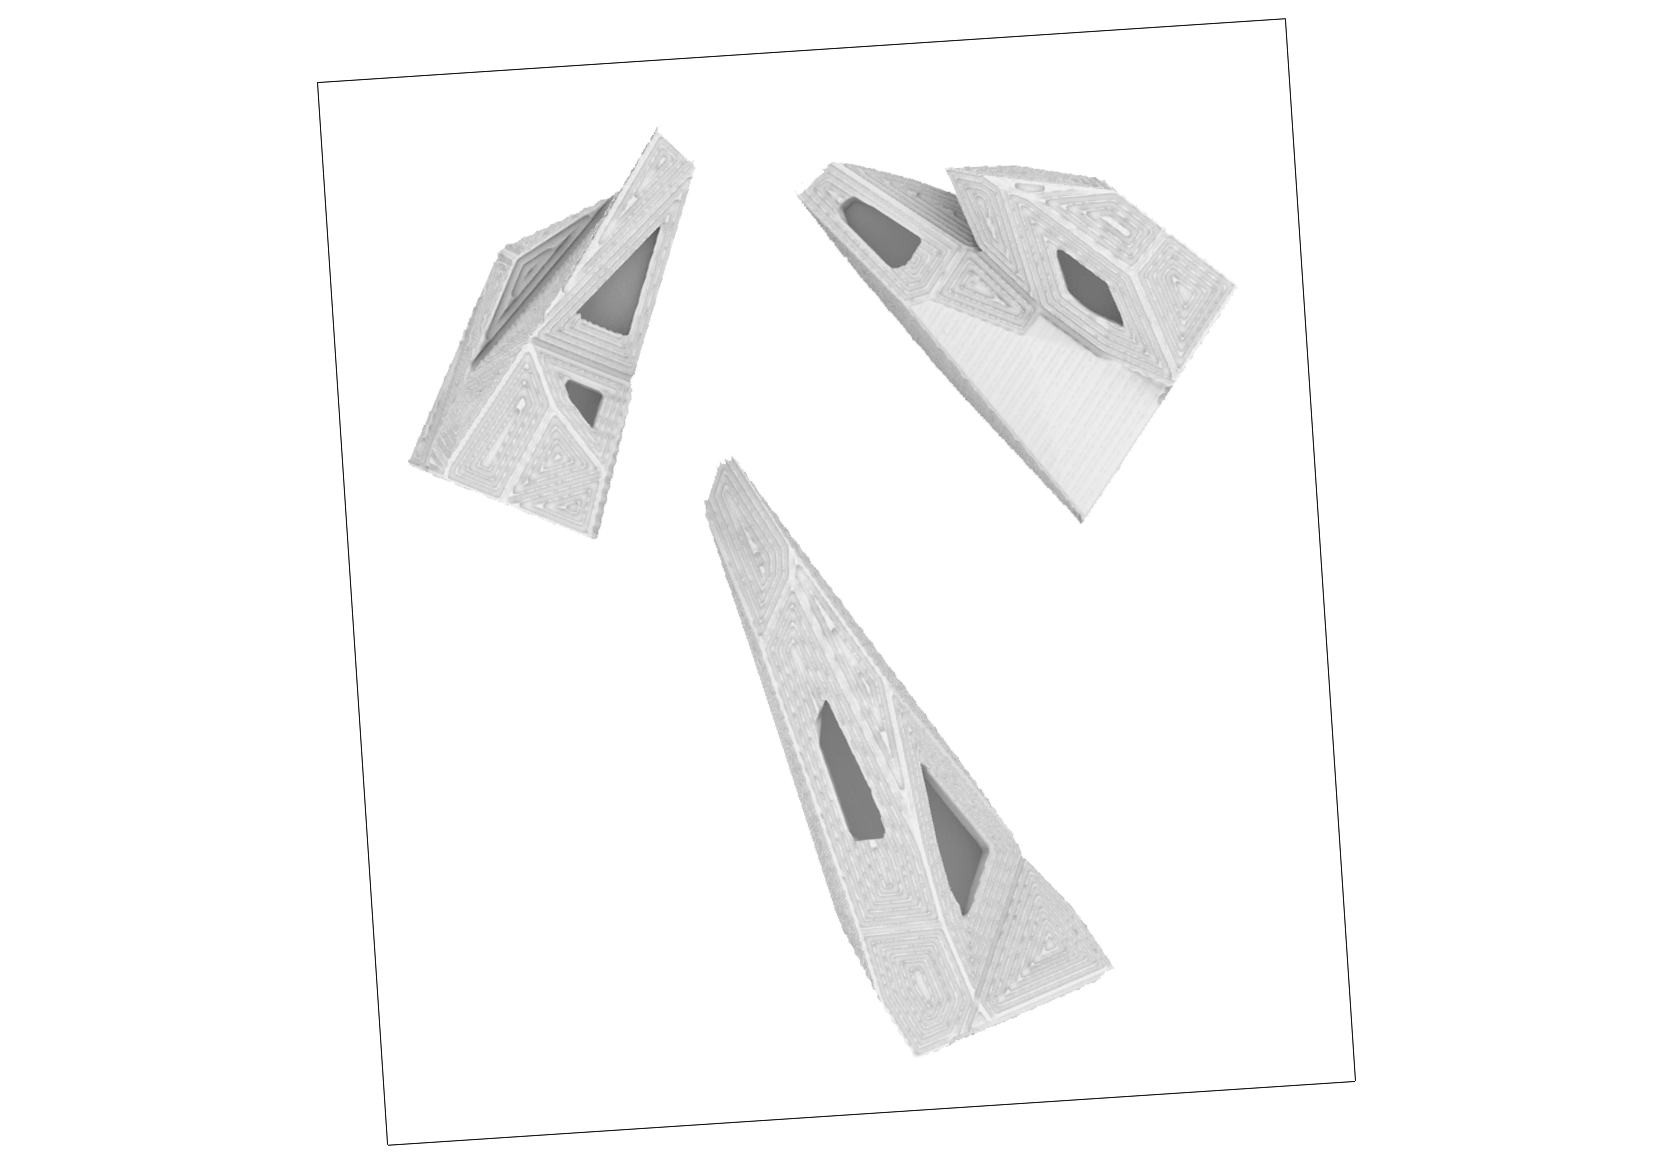

In [ ]:
# Open the background and foreground images

background_url = "https://i.ibb.co/PgsnSnt/Background-2.png"
foreground_url = "https://i.ibb.co/BBdJpHy/Foreground.png"

background = Image.open(requests.get(background_url, stream=True).raw,)
foreground = Image.open(requests.get(foreground_url, stream=True).raw,)

# Show previews of the background and foreground images
background.show()
foreground.show()

Now we can overlay the two images over each other to create an image that simulates what our robotic arm will see in the lab.

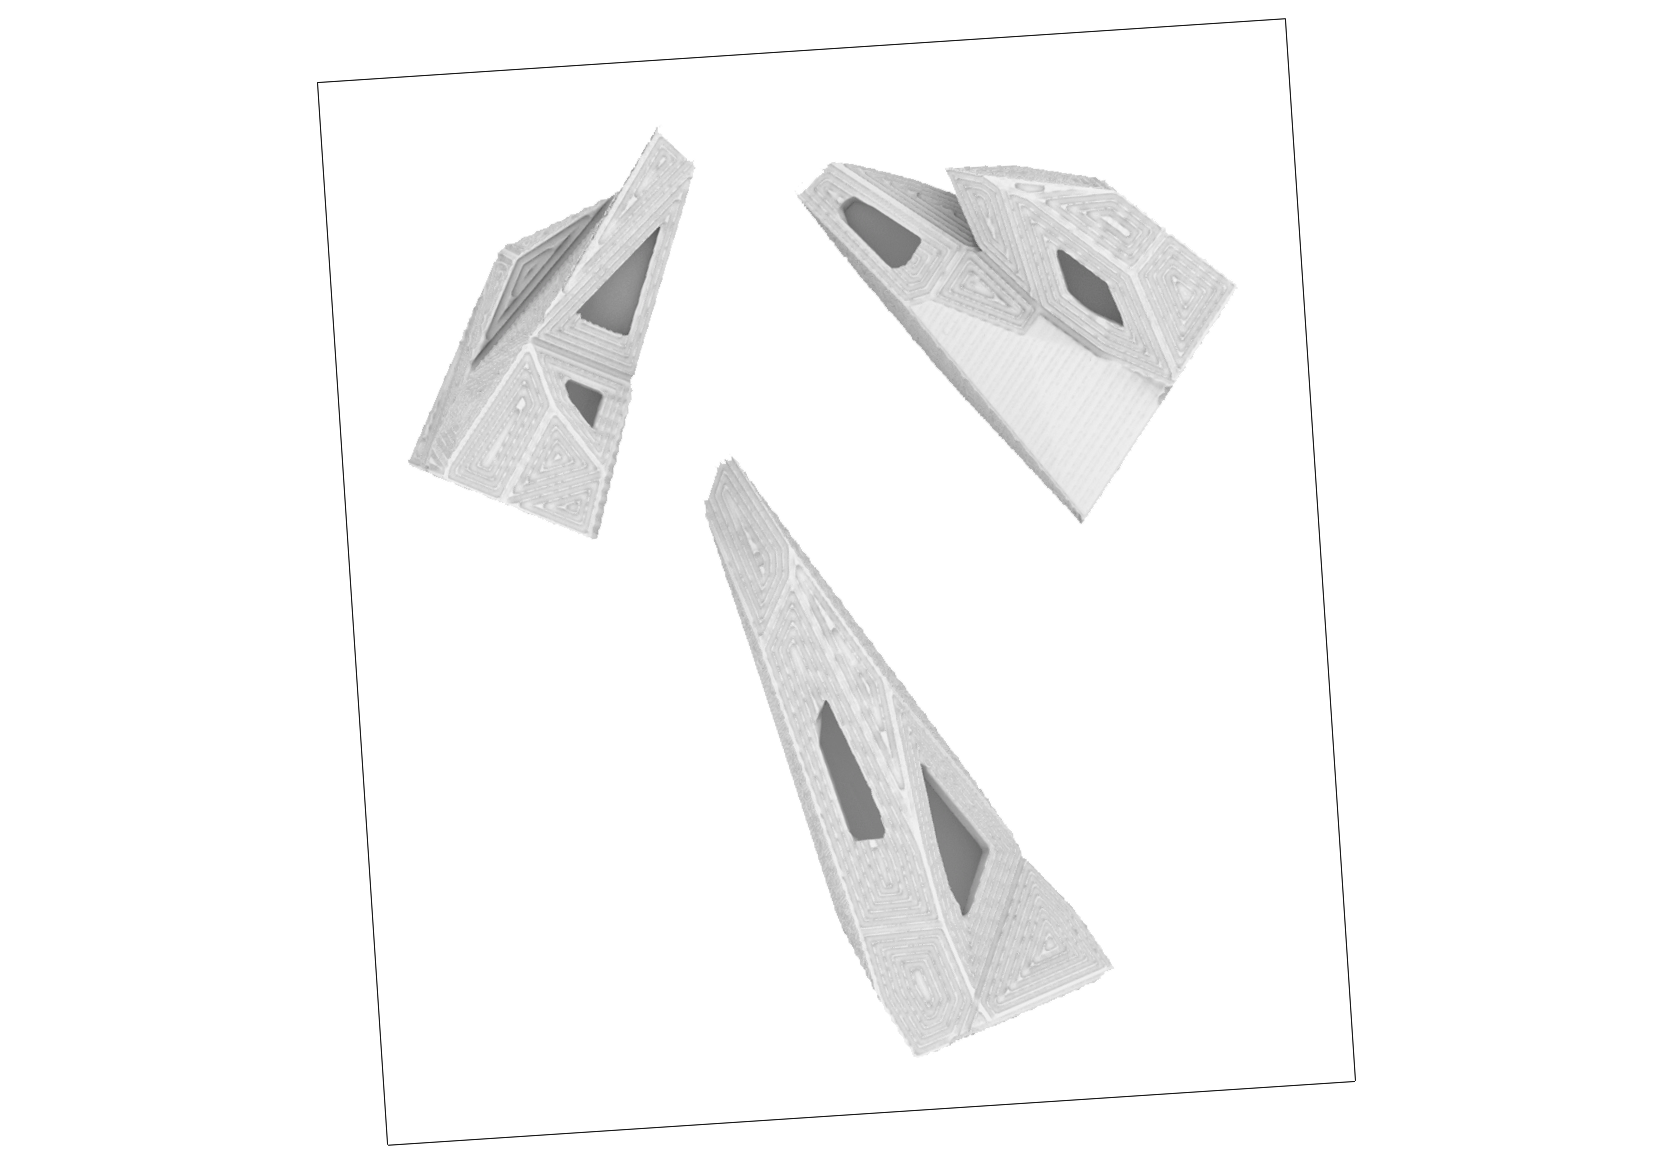

In [ ]:
# Brighten the background image. This will help in the future for detecting the fragments by increasing contrast.
enhancer = ImageEnhance.Brightness(background)
background = enhancer.enhance(10)

# Resize the foreground image to fit the background image
foreground = foreground.resize(background.size)

# Convert the background image to the mode of the foreground image
background = background.convert(foreground.mode)

# Create a new image by compositing the background and foreground images
image = Image.alpha_composite(background, foreground)

# Show the result
image.show()

If all works well, you should now see a single image that adds an off-white background to the fragments that we will be working with.

## Reference Frame Alignment

In the image above, the frame indicates the pick region. The frame, the rectangular boundary around the 3 components, is slightly rotated. Ideally, we would have an image showing the frame 1) axis-aligned, and 2) such that the frame is exactly the size of the image. The latter is important because we generally know the size of the frame; from which subsequently the object properties can be estimated if the object's geometry is known.

This challenge - here refered to as perspective warping - will be solved in 4 consecutive steps:

- ***Edge detection*** to detect the edges in the image; this makes it easier for to find the frame in the next step.
- ***Frame detection*** which detects the frame contour from the image. 
- ***Perspective warp*** to rotate and scale the image.
- ***Black pixel removal*** to make sure the frame is not visible in the final image.

Before beginning, convert the image to grayscale if it is not already. If it is already grayscale, ignore this step. If you get an error, it mostly likely is because the image is already grayscale and you can try the next kernel.

In [ ]:
import cv2

# Convert the image to grayscale
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

The frame is detected using a contour finding technique; a function native to the Open-CV libary: cv2.findContours(). Usually, some pre-processing is necessary to make this function find the appropriate contours. For pre-processing, we will use edge detection.

Shape of the grayscale image: (1165, 1654)
Shape of the edge image: (1165, 1654)


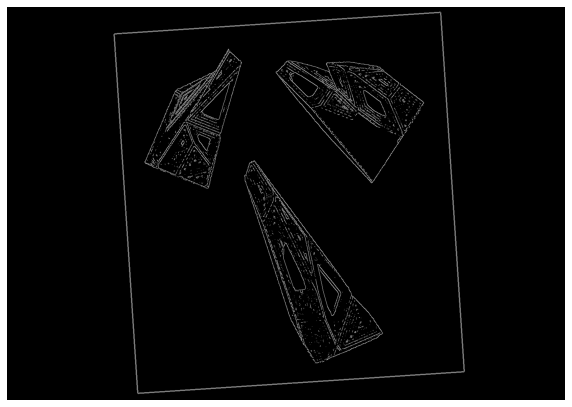

In [ ]:
import numpy as np

ex = 100 #@param 
ey = 100 #@param
image_edge = iacv.edge(image, e_range=[ex, ey])
iacv.imshow(image_edge)

# Check the shape of the grayscale image
print(f"Shape of the grayscale image: {image.shape}")

# Check the shape of the edge image
print(f"Shape of the edge image: {image_edge.shape}")

Now we can find the contours of this image. We will do so using the `cv2.findContours` functions which is a well-known and quite robust contour finding method ([original 1985 paper](https://www.sciencedirect.com/science/article/abs/pii/0734189X85900167)). As with any function, it has many tweakable parameters. 

The first is the **image** it works on; the second the **retrieval mode** ; and the third the utilized **algorithm**. We are only interested in the outer contour, so we choose `cv2.RETR_EXTERNAL`, and use an approximate function `cv2.CHAIN_APPROX_TC89_L1`.

In [ ]:
cnts, hierarchy = cv2.findContours(image_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

print(f"The number of detected contours: {len(cnts)}")
print(f"First contour: {cnts[0].squeeze()}")
print(f"Length of first contour, ie number of points: {len(cnts[0])}")

The number of detected contours: 1
First contour: [[1281   17]
 [1266   18]
 [1251   19]
 [1236   20]
 [1221   21]
 [1206   22]
 [1190   23]
 [1175   24]
 [1160   25]
 [1145   26]
 [1130   27]
 [1115   28]
 [1099   29]
 [1098   30]
 [1083   31]
 [1068   32]
 [1053   33]
 [1038   34]
 [1023   35]
 [1007   36]
 [ 992   37]
 [ 977   38]
 [ 962   39]
 [ 947   40]
 [ 932   41]
 [ 918   41]
 [ 933   42]
 [ 917   44]
 [ 901   43]
 [ 916   42]
 [ 902   42]
 [ 887   43]
 [ 872   44]
 [ 857   45]
 [ 842   46]
 [ 827   47]
 [ 811   48]
 [ 796   49]
 [ 781   50]
 [ 766   51]
 [ 751   52]
 [ 736   53]
 [ 720   54]
 [ 705   55]
 [ 690   56]
 [ 675   57]
 [ 660   58]
 [ 645   59]
 [ 629   60]
 [ 614   61]
 [ 613   62]
 [ 598   63]
 [ 583   64]
 [ 568   65]
 [ 553   66]
 [ 538   67]
 [ 522   68]
 [ 507   69]
 [ 492   70]
 [ 477   71]
 [ 462   72]
 [ 447   73]
 [ 431   74]
 [ 416   75]
 [ 401   76]
 [ 386   77]
 [ 371   78]
 [ 356   79]
 [ 340   80]
 [ 325   81]
 [ 318   81]
 [ 326   82]
 [ 318   83]
 

The algorithm nicely found one contour, but ... the amount of coordinates is huge. It doesn't know what shape the reference frame is. We do, namely a square. The OpenCV library has two functions that can find the closest rectangle to a set of points: `cv2.minAreaRect()` and `cv2.boxPoints`. Let's implement it.

In [ ]:
cnt = cnts[0]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
print(box)

[[ 315.41254    80.68634 ]
 [1286.2957     16.640198]
 [1356.595    1082.3162  ]
 [ 385.7118   1146.3623  ]]


We will use the shapely library to convert contours of any form to closed-loop polygons. We can simply call shapely.geometry.Polygon and only input the coordinates of every contour to generate what we want. (shapely is a proper geometry library in Python in which handling geometric object such as points, lines, polygons, and more complex ones.)

In [ ]:
from shapely.geometry import Polygon

polygon = Polygon(box)
print(polygon)

POLYGON ((315.41253662109375 80.68634033203125, 1286.295654296875 16.64019775390625, 1356.594970703125 1082.316162109375, 385.7117919921875 1146.3623046875, 315.41253662109375 80.68634033203125))


Let's plot the polygon on top of the original image.

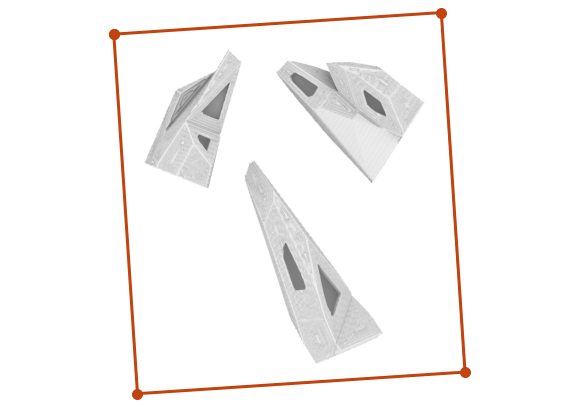

In [ ]:
import matplotlib.pyplot as plt

# Let's use a martian dirt color in line with the context that we are designing in!
mars_color = "#c1440e"

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

# plot image; plot polygon 
# (you can simply plot them by writing two lines!)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)) # add cv2.cvtColor here to convert the grayscale image to RGB
# set color, marker type, markersize, and linewidth to your preference!
iacv.plot_polygon(polygon, ax, color=mars_color, marker='o', markersize=10, linewidth=3)

You should now see that the frame has been found. Let's warp it now. This function can be found the `iacv` library: `iacv.warp`. Make sure to input the contour and not the polygon!

Shape of the warped image:	(972, 1067)
Shape of the original image:	(1165, 1654)


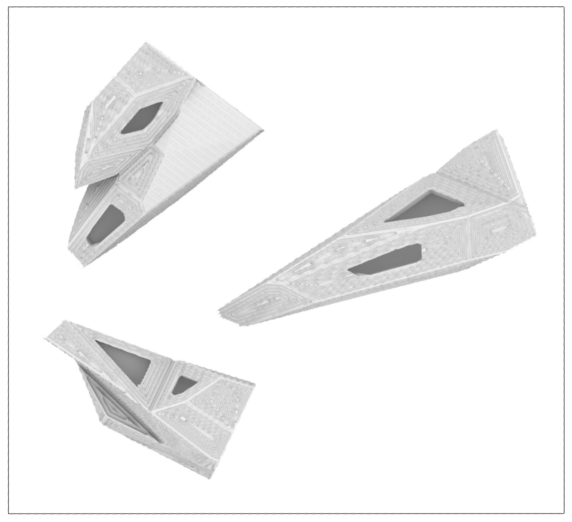

In [ ]:
image_warp = iacv.warp(image, cnt)
iacv.imshow(image_warp)
print(f"Shape of the warped image:\t{image_warp.shape}") 
print(f"Shape of the original image:\t{image.shape}") 

Everything should be orthogonal and axis-aligned now. (Note also that the dimensions are correct; the warp did not stretch or strangely modified the content.)

---

Let's get rid of the black edges: `iacv.border2color`. (Make sure the image is RGB before it is passed to the border2color function)

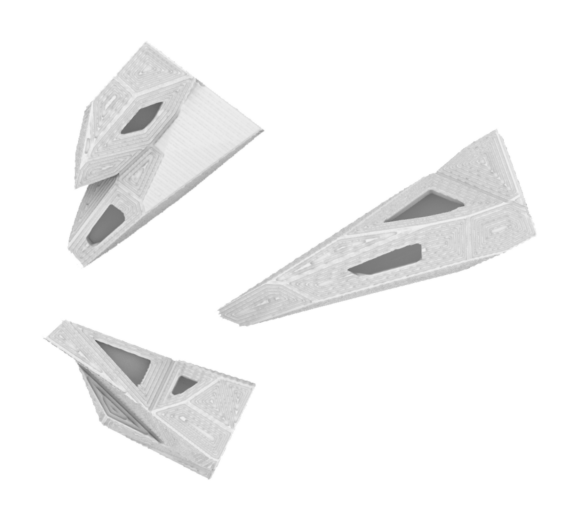

In [ ]:
# Before we can pass the image to the iacv.border2color function, we should make sure that it is in fact RGB. The below if/elif statements ensure that this works by converting it to RGB.

if len(image_warp.shape) == 2:
    # Convert grayscale image to RGB
    image_warp = cv2.cvtColor(image_warp, cv2.COLOR_GRAY2RGB)
elif len(image_warp.shape) == 3 and image_warp.shape[2] == 1:
    # Convert single-channel image to RGB
    image_warp = cv2.cvtColor(image_warp, cv2.COLOR_GRAY2RGB)

image_warp = iacv.border2color(image_warp, off=10) #Don't mess with the 'off' parameter, keep it at 10 for this purpose
iacv.imshow(image_warp)

---
The size of the square in which the fragments are placed is 82x74.8 cm. We can compute the amount of pixels that occupies 1 cm, or in other word the **pixel per centimeter** (ppcm). We can simply compute it by `iacv.pixpermetric`. Make sure to put the correct metric argument ('cm' in this case).

In [ ]:
print(f"Shape of the warped image: {image_warp.shape}") 
ppcm = iacv.pixpermetric(image_warp, 82, metric='cm', show=True)

Shape of the warped image: (972, 1067, 3)
Pixels per cm in X and Y = 13.01


If the width is 82cm then a ppcm value of 13.01 should be correct. This means that for every centimeter in the physical world, there are 13.01 pixels in the digital image. 

You can check if the ppcm is correct by dividing the shape of the warped image with the ppcm and seeing if it matches the real world measurement.

## Detect and allocate component of interest

Now it is time to start isolating the building fragments within the image. In order to detect components of interest in the image, we need to visually separate the background from the foreground.

 To do this, we apply various image processing techniques including blurring (from IACV), pyramidal mean-shift filtering (from CV2), and edge detection to generate a black and white image with clear object boundaries. We can then use a similar strategy of detecting contours to isolate the components of interest.

Ensure that you modify the `thresh`, `ex` and `ey` parameters to work with your specific image.

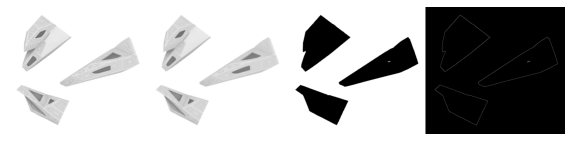

In [ ]:
image = image_warp
image = iacv.blur(image, ksize=7)
image = cv2.pyrMeanShiftFiltering(image, 10, 10)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

thresh = 236 #@param
image_thresh = np.where(image_gray < thresh, 0.0, 255.0)
image_thresh = np.uint8(image_thresh)

ex = 20  #@param 
ey = 20  #@param
image_warp_edge = iacv.edge(image_thresh, e_range=[ex, ey])

image_stack = iacv.concat_images_horizontally([image_warp,
                                             image_gray, 
                                             image_thresh,
                                             image_warp_edge])
iacv.imshow(image_stack)

Now that we have clearly visually separated the foreground from the background, we can draw contours to identify the boundaries of each object.

The number of detected contours: 3


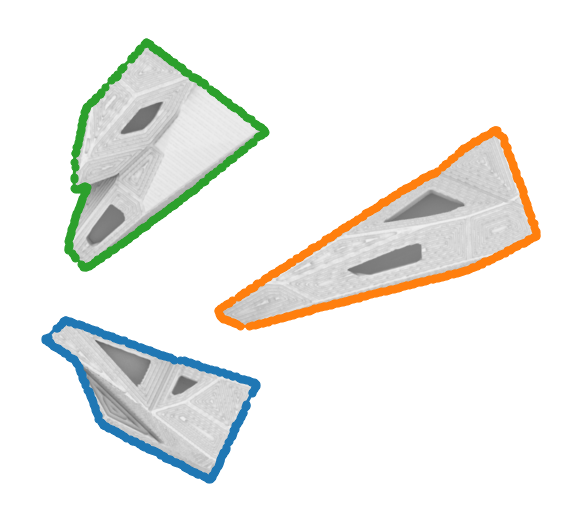

In [ ]:
cnts, hierarchy = cv2.findContours(image_warp_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")
polygons = iacv.contours2polygons(cnts)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

ax.imshow(image_warp)
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

Too many points! Use the below code to simplify the contours while still maintaining the overall shape. 

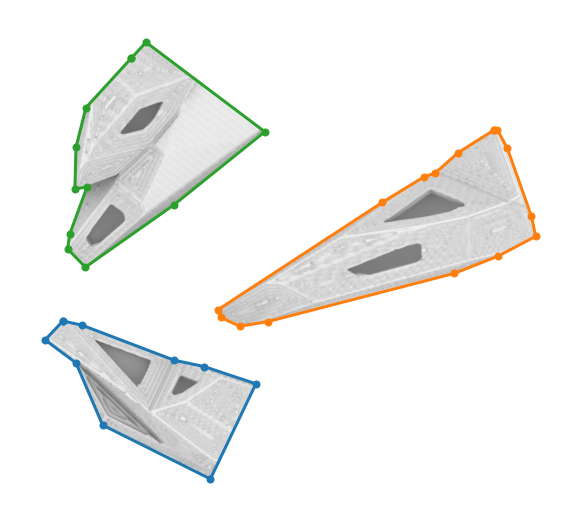

In [ ]:
import numpy as np

polygons_simplified = iacv.simplify_polygons(polygons)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

ax.imshow(image_warp)
for pol in polygons_simplified:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

We can now begin focusing on a single element. In order to do this, We need another package: `rasterio`. The `rasterio.features.rasterize` module can rasterize our geometric object.

Install `rasterio` using the below code if you haven't already.

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 62.1 MB/s eta 0:00:00


Now we can use rasterio to select different individual fragments to use as a mask.

You can modify the index value to choose a different polygon to use as the mask. 

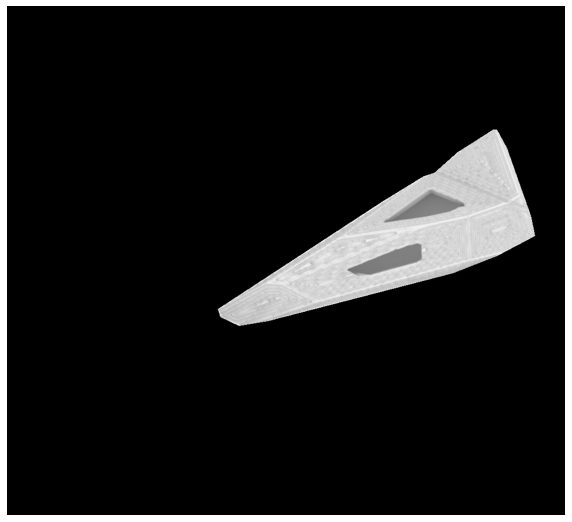

In [ ]:
from rasterio import features

polygon_index = 1 #@param {type:"slider", min:0, max: 2, step:1}
mask = features.rasterize([polygons_simplified[polygon_index]], out_shape=image_warp.shape[:2])
img_warp_c1 = image_warp * np.stack([mask]*3, axis=2)
iacv.imshow(img_warp_c1)

## Find Holes

The only thing that remains is to guide our robotic hand to a point where it can easily grab the component. As you know, the robotic arm can best grab the component through one of it's holes. We will find the holes and largest edge (including angle) again with the same contour finding technique.

The number of detected contours: 97


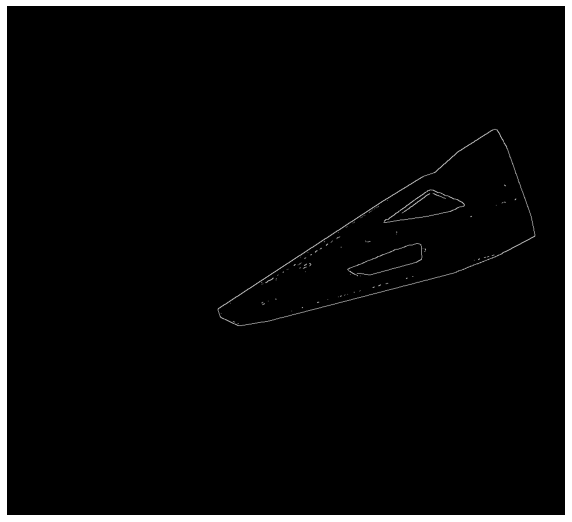

In [ ]:
image = img_warp_c1
image = iacv.blur(image, ksize=5)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# edge
ex = 100 #@param
ey = ex
image = iacv.edge(image, e_range = [ex, ey])
iacv.imshow(image)

# find contours
cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1 )
print(f"The number of detected contours: {len(cnts)}")

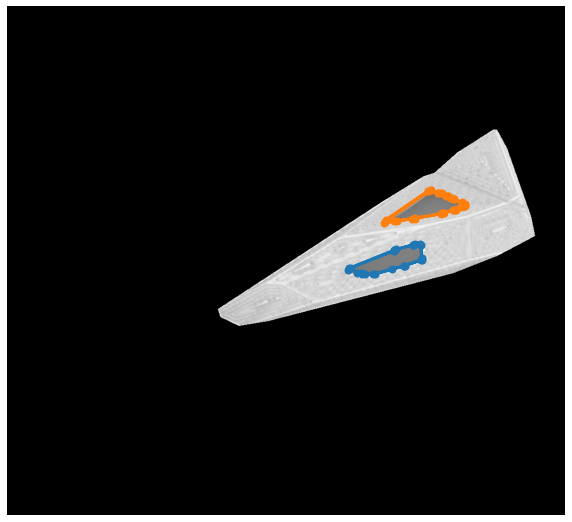

In [ ]:
a_min = 30 #@param
a_max = 800 #@param

polygons = iacv.get_hole_polygons_from_contours(cnts, a_min, a_max)

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

# plot image; plot polygon 
# (you can simply plot them by writing two lines!)
ax.imshow(img_warp_c1)
# set color, marker type, markersize, and linewidth to your preference!
for pol in polygons:
  iacv.plot_polygon(pol, ax, marker='o', markersize=7, linewidth=3)

We can now determine the center points of one of the two polygons that describes the hole. More precisely, we will guide robotic arm towards the longest edge; give the middle point of that edge; and it relative (to the frame) orientation.

Use the polygon_index slider to change the polygon.

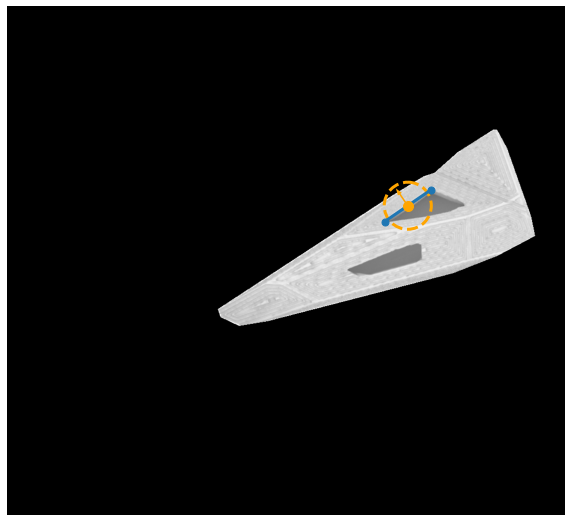

In [ ]:
from shapely.geometry import LineString, Point
import math

polygon_index = 1 #@param {type:"slider", min:0, max: 1, step:1} 
pol = polygons[polygon_index]

# fig settings
fs = 10
fig, ax = plt.subplots(1,1,figsize=(fs, fs))
ax.axis('off')

centroid, angle = iacv.plot_robot_grab(img_warp_c1, pol, ax)

This should identify which edge the robotic arm should grab.